""" Rb Raman pulse scan
    Preston Huft, May 2019  
    
    TODO: 
        - account for non-zero atom trap site radius
"""

In [28]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import complex_ode,odeint
from scipy.integrate import solve_ivp
import sympy
from sympy import MatrixSymbol,MatAdd,MatMul,Identity,I,Matrix,symbols
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy.utilities.iterables import flatten
import time
from math import pi,sqrt

In [33]:
## physical constants
ee = 1.60217662e-19 # [C]
a0 = 5.22e-11 # [m]
hbar = 1.0545718e-34 # [J s]
c = 3e8 # [m]
e0 = 8.85418782e-12 # [m^-3 kg^-1 s^4 A^2]

In [44]:
###############################################################################
## METHODS and GLOBAL PARAMETERS
###############################################################################

def cc(z): 
    return np.conj(z)  

def Intensity(P,w0,r,A=None,r0=None):
    """ Gaussian beam intensity at radius 'r' for
        'P' power
        'w0' beam waist
        'A' area
    """
    if r0 is None:
        r0 = 0
    if A is None:
        A = pi*w0**2
    
    return (P/A)*np.exp(-2*(r-r0)**2/(w0**2))

def z_rayleigh(w0,wl):
    return (pi*w0**2)/wl

def g_waist(z,w0,zR):
    return w0*sqrt(1+(z/zR)**2)  

def derivs(y0,t,D1,D2,O1,O2):
    cg,ce = y0
    
    # See Mark's notes, eqs 11.14. Intermediate level r eliminated.
    
    D = D1-D2 # resonant when the single-photon detunings cancel
    DD1 = D - cc(O1)*O1/(D1+D2)
    DD2 = D + cc(O2)*O2/(D1+D2)
    OR = O1*cc(O2)/(D1+D2)
    
    dcg = -1j*(DD1*cg-cc(OR)*ce)/2
    dce = 1j*(DD2*ce+OR*cg)/2
    
    return np.array([dcg,dce])

lmbda = 7.8e-7 # [m] wavelength

 # see rb_matrix_elements; these include the electron charge
o1DipoleElem = -1.792e-29
o2DipoleElem = 1.792e-29

C:\Users\gothr\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: ComplexWarning: Casting complex values to real discards the imaginary part


comp time = 1.5937390327453613s
max Rabi freq. = 2pi x 39741


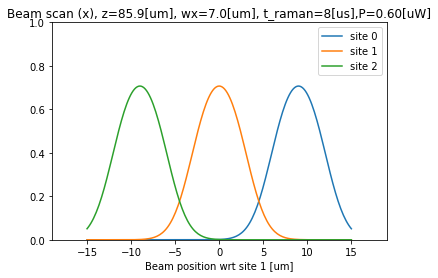

In [245]:
###############################################################################
## Raman 8 us pulse beam position scan for three atom sights
###############################################################################

## initial conditions - system starts in ground state (|F=2,mF=0>)
c_g = 1 + 0j
c_e = 0 + 0j
y0 = np.array([c_g,c_e]) # bundle i.c.

## empirical parameters and pertinent quantities
P = 2*(.60e-6) # [W] beam power per sideband at atoms
D1 = D2 = 2*pi*(4.5e10) # [Hz] single-photon detuning
spacing = 9e-6 # [m] spacing between atom sights in x direction

# experiment lists/variables 
pts = 201 # data pts to plot per atom site
r_vals = np.linspace(-15e-6,15e-6,pts) # the positions to scan 
sites = 3 # number of atom sites
D_arr = [0,0,0] # site-specific detuning due to different trap depths
dr = [-spacing,0,spacing]

t_exp = 8 # [us] # raman pulse duration

## Beam waist and area arrays:
w0x = 6e-6 # [m] w0 in x direction
w0y = 8e-6 # [m] w0 in y direction
zRx = z_rayleigh(w0x,lmbda) 
zRy = z_rayleigh(w0y,lmbda)

z_vals = np.linspace(0,zRy,4) 
x_waists = np.array([g_waist(z,w0x,zRx) for z in z_vals])
A_vals = np.array([pi*g_waist(z,w0x,zRx)*g_waist(z,w0y,zRy) for z in z_vals])

z=1 # 0 is at focus, -1 is at Rayleigh range
wx = x_waists[z] # waist at x
A = A_vals[z] # area at z=0

## initialize the figure
fig = plt.figure()
ax = fig.add_subplot(111)

## the results arrays
tpts = 100
retention = [] # rename this later!
time_solns = []

ctime = time.time()
for s in range(0,sites): # iterate over the sites

    # The two-photon Rabi frequency
    O_vals = (2/(c*e0*hbar**2))*Intensity(P,wx,r_vals+dr[s],A,r0=None) \
        *o1DipoleElem*o2DipoleElem \
        /(D1+D2)
    
#     print(max(abs(O_vals/(2*pi*1e6))))
    
    retention.append(np.empty(len(r_vals)))
    time_solns.append(np.empty(len(r_vals),dtype=list))
    
    for i,O in enumerate(O_vals/(1e6)): # iterate over Rabi freq. vals 

        # The single-photon Rabi frequency
        # Assume O1=O2=O, which is true if |r>=|5p3/2,F=2,mF=1>
        O1=O2=sqrt(abs(O*(D1+D2)))
            
        func = lambda time,y: derivs(y,time,D1,D2,O1,O2)
        
        soln = solve_ivp(func,[0,t_exp],y0,t_eval=np.linspace(0,t_exp,tpts))
        
        time_solns[s][i]=[cc(y)*y for y in soln.y[1]] # prob(|g>)
        retention[s][i]=time_solns[s][i][-1]
        

ctime = time.time() - ctime
print(f"comp time = {ctime}s")

## plot position scan results
ax.set_ylim((0,1))
ax.set_xlim(-19,19)
ax.set_xlabel('Beam position wrt site 1 [um]')
ax.set_title(f'Beam scan (x), z={z_vals[z]/1e-6:.1f}[um], wx={wx/1e-6:.1f}[um],\
 t_raman={t_exp}[us],P={P/(2e-6):.2f}[uW]')
for i,site in enumerate(retention):
    ax.plot(r_vals*1e6,site,label=f"site {i}")
    
## plot the oscillations in time for a given site and rabi freq
# ax.set_ylim((0,1))
# ax.set_xlim((0,t_exp))
# ax.set_xlabel('time [us]')
# ax.set_title('Raman Rabi oscillations')
# ax.plot(soln.t,time_solns[1][int((pts-1)/2)])
Omax=abs(((2/(c*e0*hbar**2))*Intensity(P,wx,0,A,r0=None) \
        *o1DipoleElem*o2DipoleElem \
        /(D1+D2))/(2*pi))
print(f"max Rabi freq. = 2pi x {Omax:0.0f}")

ax.legend(loc='upper right')
plt.show()

z = 0: 

$\ $P = .47 $\mu$W, O $\approx$ 2$\pi \times$ 38 kHz 

$\ $P = 3.5 $\mu$W, O $\approx$ 2$\pi \times$ 284 kHz 

z = .25 * zR:

$\ $P = .6 $\mu$W, O $\approx$ 2$\pi \times$ 39.7 kHz 

z = .5 zR:

$\ $P = .9 $\mu$W, O $\approx$ 2$\pi \times$ 39.2 kHz 

In [244]:
[x/3 for x in (zRx/1e-6,zRy/1e-6)]

[48.3321946706122, 85.9239016366439]